## Set up

In [1]:
"""
MAIN EXPERIMENT NOTEBOOK
Feature Inversion: ResNet34, VGG16, ViT

Project: High-Fidelity Feature Inversion
Course: CAP6415 Computer Vision - Fall 2025
"""

# Enable autoreload for easy development
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Import our modules
from models import FeatureExtractor, create_decoder
from dataset import get_dataloaders, denormalize
from train import train_decoder
from evaluate import MetricsCalculator, print_metrics
from utils import (get_device, save_comparison_grid, plot_training_history, 
                   count_parameters, set_seed)

# Set random seed for reproducibility
set_seed(42)

print("✓ Setup complete")
print(f"PyTorch version: {torch.__version__}")

✓ Random seed set to 42
✓ Setup complete
PyTorch version: 2.9.0


## Configuration

In [9]:
CONFIG = {
    # Architecture settings
    'architecture': 'resnet34',
    'layer_name': 'layer3',
    'decoder_type': 'attention',  # Test with attention this time
    
    # Data settings
    'data_dir': '../data/DIV2K_train_HR',
    'img_size': 224,
    'batch_size': 8,
    'limit': 100,  # Keep small for fast test
    
    # Training settings
    'num_epochs': 5,  # Just 5 epochs for quick test
    'lr': 1e-3,
    'weight_decay': 1e-5,
    
    # Device
    'device': get_device()
}

Using Apple MPS (Metal Performance Shaders)


## Downloading Dataset

In [3]:
"""
Download DIV2K Dataset

Run this cell ONCE to download the dataset.
If you already have DIV2K, skip this cell and update 'data_dir' in CONFIG.
"""

import urllib.request
import zipfile
import os

data_dir = Path('../data')
data_dir.mkdir(exist_ok = True)

# DIV2K download URL (train set, high resolution)
url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip'
zip_path = data_dir / 'DIV2K_train_HR.zip'

if not (data_dir / 'DIV2K_train_HR').exists():
    print("Downloading DIV2K dataset (~2.2 GB)...")
    print("This may take 10-20 minutes depending on your connection...")
    
    urllib.request.urlretrieve(url, zip_path)
    print("✓ Download complete!")
    
    print("\nExtracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    
    print("✓ Extraction complete!")
    
    # Update config
    CONFIG['data_dir'] = str(data_dir / 'DIV2K_train_HR')
    print(f"\n✓ Dataset ready at: {CONFIG['data_dir']}")
else:
    print("✓ Dataset already exists")
    print(f"  Location: {data_dir / 'DIV2K_train_HR'}")

This may take 10-20 minutes depending on your connection...
✓ Download complete!

Extracting...
✓ Extraction complete!


NameError: name 'CONFIG' is not defined

## Creating Data Loaders

✓ Found 100 images in ../data/DIV2K_train_HR
✓ Found 20 images in ../data/DIV2K_train_HR

✓ DataLoaders created:
  Training batches: 13
  Validation batches: 3
  Batch shape: torch.Size([8, 3, 224, 224])


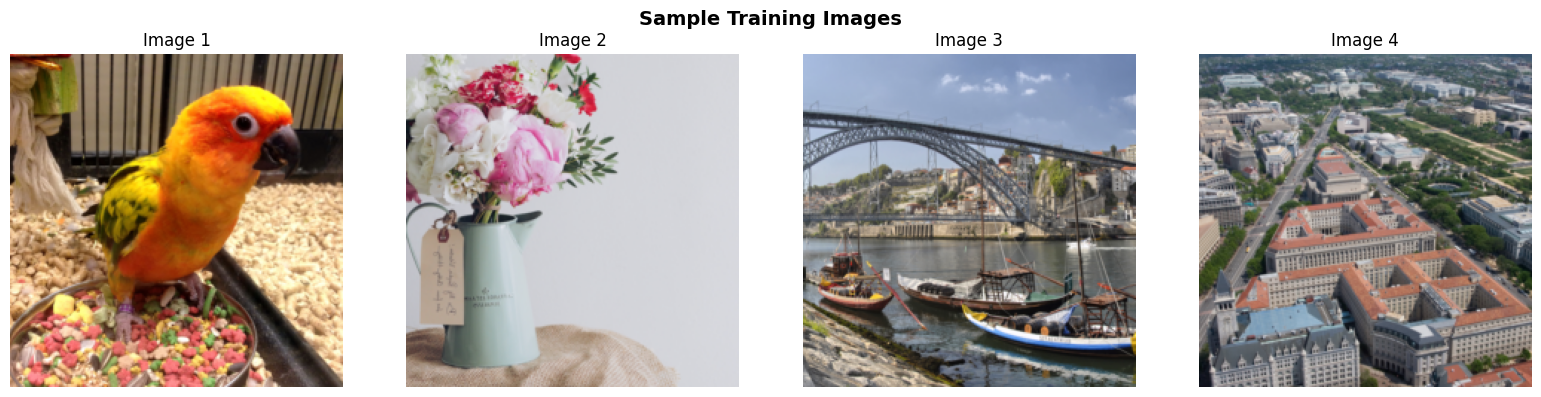


✓ Sample images saved to results/figures/sample_data.png


In [3]:
"""
Create data loaders for training and validation.

This splits the data and applies appropriate transforms.
"""

train_loader, val_loader = get_dataloaders(
    data_dir = CONFIG['data_dir'],
    img_size = CONFIG['img_size'],
    batch_size = CONFIG['batch_size'],
    num_workers = 'auto',  # Auto-detects Windows vs Mac
    limit = CONFIG['limit']
)

print(f"\n✓ DataLoaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

# Visualize sample data
test_batch = next(iter(train_loader))
print(f"  Batch shape: {test_batch.shape}")

fig, axes = plt.subplots(1, 4, figsize = (16, 4))
for i in range(4):
    img = denormalize(test_batch[i]).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.suptitle("Sample Training Images", fontsize = 14, fontweight = 'bold')
plt.tight_layout()
plt.savefig('../results/figures/sample_data.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print(f"\n✓ Sample images saved to results/figures/sample_data.png")

## Creating Models

In [4]:
"""
Create encoder (feature extractor) and decoder.

The encoder is frozen (pre-trained weights, no training).
The decoder is trained to invert the features.
"""

print(f"\n{'='*60}")
print("CREATING MODELS")
print(f"{'='*60}\n")

# Create feature extractor (frozen encoder)
encoder = FeatureExtractor(
    architecture=CONFIG['architecture'],
    layer_name=CONFIG['layer_name']
)

print(f"✓ Encoder: {CONFIG['architecture']} - {CONFIG['layer_name']}")
print(f"  Parameters: {count_parameters(encoder):,} (frozen)")

# Get feature shape to configure decoder
dummy_input = torch.randn(1, 3, CONFIG['img_size'], CONFIG['img_size'])
with torch.no_grad():
    dummy_features = encoder(dummy_input)
    feat_shape = dummy_features.shape

print(f"  Input shape: {dummy_input.shape}")
print(f"  Feature shape: {feat_shape}")

# Create decoder
decoder = create_decoder(
    decoder_type = CONFIG['decoder_type'],
    input_channels = feat_shape[1],
    input_size = feat_shape[2],
    output_size = CONFIG['img_size']
)

print(f"\n✓ Decoder: {CONFIG['decoder_type']}")
print(f"  Parameters: {count_parameters(decoder):,} (trainable)")

# Test forward pass
with torch.no_grad():
    dummy_recon = decoder(dummy_features)
    print(f"  Output shape: {dummy_recon.shape}")

assert dummy_recon.shape == dummy_input.shape, "Shape mismatch!"
print(f"\n{'='*60}")
print("✓ Models created successfully!")
print(f"{'='*60}\n")


CREATING MODELS

✓ Encoder: resnet34 - layer3
  Parameters: 0 (frozen)
  Input shape: torch.Size([1, 3, 224, 224])
  Feature shape: torch.Size([1, 256, 14, 14])

✓ Decoder: simple
  Parameters: 706,147 (trainable)
  Output shape: torch.Size([1, 3, 224, 224])

✓ Models created successfully!



## Training

In [10]:
"""
Train the decoder.

This implements the optimization from Chapter 33:
    minimize E_x[(x - g_ψ(f_θ(x)))²]

Training will take:
- ~5-10 minutes for 100 images, 20 epochs on GPU
- ~20-30 minutes for 100 images, 20 epochs on CPU
- ~1-2 hours for full dataset (800 images) on GPU
"""

print(f"\n{'='*60}")
print("STARTING TRAINING")
print(f"{'='*60}\n")



# Train with updated function signature
history = train_decoder(
    encoder=encoder,
    decoder=decoder,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    device=CONFIG['device'],
    save_dir='../results'  # Changed from '../results/checkpoints'
)

# Plot with updated function signature
plot_training_history(history, CONFIG)  # Now takes config instead of path


print("\n✓ Training complete!")
print("✓ Best model saved to: results/checkpoints/best_decoder.pth")
print("✓ Training curves saved to: results/figures/training_history.png")


STARTING TRAINING


Training Configuration:
  Experiment: resnet34_layer3_attention
  Epochs: 5
  Learning Rate: 0.001
  Batch Size: 8
  Device: mps
  Train Batches: 13
  Val Batches: 3


Epoch 1/5


Validating: 100%|█████████████████████████████████| 3/3 [00:17<00:00,  5.68s/it]



Epoch 1 Summary:
  Train Loss: 0.961597
  Val Loss:   0.844460
  LR:         1.00e-03
  [SAVED] Best model: resnet34_layer3_attention_best.pth (val_loss: 0.844460)

Epoch 2/5


Validating: 100%|█████████████████████████████████| 3/3 [00:17<00:00,  5.68s/it]



Epoch 2 Summary:
  Train Loss: 0.936529
  Val Loss:   0.826239
  LR:         1.00e-03
  [SAVED] Best model: resnet34_layer3_attention_best.pth (val_loss: 0.826239)

Epoch 3/5


Validating: 100%|█████████████████████████████████| 3/3 [00:17<00:00,  5.69s/it]



Epoch 3 Summary:
  Train Loss: 0.939979
  Val Loss:   0.829077
  LR:         1.00e-03

Epoch 4/5


Validating: 100%|█████████████████████████████████| 3/3 [00:17<00:00,  5.71s/it]



Epoch 4 Summary:
  Train Loss: 0.925533
  Val Loss:   0.829463
  LR:         1.00e-03

Epoch 5/5


Validating: 100%|█████████████████████████████████| 3/3 [00:17<00:00,  5.70s/it]



Epoch 5 Summary:
  Train Loss: 0.921858
  Val Loss:   0.846553
  LR:         1.00e-03

Training Complete!
  Experiment: resnet34_layer3_attention
  Total Time: 3.38 minutes
  Best Val Loss: 0.826239
  Saved to: ../results/resnet34/checkpoints

[SAVED] Training history: ../results/resnet34/figures/resnet34_layer3_attention_training.png

✓ Training complete!
✓ Best model saved to: results/checkpoints/best_decoder.pth
✓ Training curves saved to: results/figures/training_history.png


## Evaluation

In [11]:
"""
Evaluate the trained decoder.

Calculates:
- PSNR: Peak Signal-to-Noise Ratio (higher is better)
- SSIM: Structural Similarity Index (higher is better)
- LPIPS: Learned Perceptual Similarity (lower is better)
- MSE: Mean Squared Error (lower is better)
"""

print(f"\n{'='*60}")
print("EVALUATION")
print(f"{'='*60}\n")


# Load best model
checkpoint = torch.load('../results/checkpoints/best_decoder.pth')
decoder.load_state_dict(checkpoint['decoder_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Training loss: {checkpoint['train_loss']:.6f}")
print(f"  Validation loss: {checkpoint['val_loss']:.6f}")

# Evaluate on validation set
metrics_calc = MetricsCalculator(device=CONFIG['device'])
results = metrics_calc.evaluate_model(
    encoder=encoder,
    decoder=decoder,
    dataloader=val_loader,
    device=CONFIG['device'],
    max_batches=20  # Evaluate on 20 batches (increase for full evaluation)
)

# Print results
print_metrics(results, f"Results: {CONFIG['architecture']}-{CONFIG['layer_name']}")

# Save results
import pandas as pd
results_df = pd.DataFrame([results])
results_df.to_csv('../results/metrics/evaluation_results.csv', index = False)
print("✓ Results saved to: results/metrics/evaluation_results.csv")


EVALUATION

✓ Loaded best model from epoch 20
  Training loss: 0.934078
  Validation loss: 0.826163
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/homebrew/Caskroom/miniforge/base/envs/cv_final/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


Evaluating: 100%|█████████████████████████████████| 3/3 [00:17<00:00,  5.76s/it]


Results: resnet34-layer3
  PSNR:  13.97 +/- 0.35 dB
  SSIM:  0.2596 +/- 0.0261
  LPIPS: 0.7193 +/- 0.0345
  MSE:   0.042219 +/- 0.002526

✓ Results saved to: results/metrics/evaluation_results.csv


## Visualizing Reconstructions

In [14]:
"""
Visualize reconstruction quality.

This cell:
1. Takes a batch of validation images
2. Reconstructs them using the trained decoder
3. Creates side-by-side comparison grid (original vs reconstructed)
4. Saves visualization to architecture-specific folder

The visual comparison helps assess:
- Overall reconstruction quality
- What details are preserved vs lost
- Color accuracy
- Structural preservation
"""

print(f"\n{'='*60}")
print("GENERATING VISUALIZATIONS")
print(f"{'='*60}\n")

# Ensure models are on correct device and in evaluation mode
# Even though we did this in previous cell, it's good practice to ensure
encoder.to(CONFIG['device'])
decoder.to(CONFIG['device'])

# Set to evaluation mode
# This disables dropout and makes batch normalization use running statistics
# Critical for consistent, deterministic outputs
encoder.eval()
decoder.eval()

# Get a batch of test images from validation loader
# [:8] takes first 8 images from the batch
# We use validation set (not training set) to show generalization
test_images = next(iter(val_loader))[:8].to(CONFIG['device'])

print(f"Processing {test_images.shape[0]} test images...")

# Reconstruct images
# We use torch.no_grad() because:
# 1. We're not training (no gradients needed)
# 2. Saves memory
# 3. Faster computation
with torch.no_grad():
    # Step 1: Extract features from encoder
    # z = f_theta(x)
    # Example: ResNet34 layer3 converts [8, 3, 224, 224] -> [8, 256, 14, 14]
    features = encoder(test_images)
    
    # Step 2: Reconstruct from features
    # x_hat = g_psi(z)
    # Decoder converts [8, 256, 14, 14] -> [8, 3, 224, 224]
    reconstructed = decoder(features)

# Save comparison grid using UPDATED function
# IMPORTANT: Function signature changed!
# OLD: save_comparison_grid(original, reconstructed, path_string, num_images)
# NEW: save_comparison_grid(original, reconstructed, config, num_images)
# 
# The function now:
# 1. Takes CONFIG dict instead of explicit path
# 2. Automatically creates experiment name from CONFIG
# 3. Saves to architecture-specific folder
# 4. Denormalizes images for display
# 5. Creates 2-row grid (original top, reconstructed bottom)
save_comparison_grid(
    original = test_images,
    reconstructed = reconstructed,
    config = CONFIG,  # Pass CONFIG dict (NOT a path string!)
    num_images = 8
)

# Print completion message
experiment_name = f"{CONFIG['architecture']}_{CONFIG['layer_name']}_{CONFIG['decoder_type']}"
print(f"\n[COMPLETE] Visualizations saved!")
print(f"Location: results/{CONFIG['architecture']}/figures/{experiment_name}_reconstruction.png")


GENERATING VISUALIZATIONS

Processing 8 test images...
[SAVED] Reconstruction comparison: ../results/resnet34/figures/resnet34_layer3_attention_reconstruction.png

[COMPLETE] Visualizations saved!
Location: results/resnet34/figures/resnet34_layer3_attention_reconstruction.png


## Summary

In [13]:
"""
Experiment Summary

Displays complete results and file locations for this experiment.
Provides quick overview of what was accomplished.
"""

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)

# Display experiment configuration
print(f"\n📊 CONFIGURATION:")
print(f"  Architecture: {CONFIG['architecture']}")
print(f"  Layer: {CONFIG['layer_name']}")
print(f"  Decoder: {CONFIG['decoder_type']}")
print(f"  Training samples: {len(train_loader.dataset)}")
print(f"  Validation samples: {len(val_loader.dataset)}")
print(f"  Epochs: {CONFIG['num_epochs']}")
print(f"  Device: {CONFIG['device']}")

# Display final results
print(f"\n📈 RESULTS:")
print(f"  PSNR:  {results['psnr_mean']:.2f} +/- {results['psnr_std']:.2f} dB")
print(f"  SSIM:  {results['ssim_mean']:.4f} +/- {results['ssim_std']:.4f}")
print(f"  LPIPS: {results['lpips_mean']:.4f} +/- {results['lpips_std']:.4f}")
print(f"  MSE:   {results['mse_mean']:.6f} +/- {results['mse_std']:.6f}")

# Create experiment name for file paths
experiment_name = f"{CONFIG['architecture']}_{CONFIG['layer_name']}_{CONFIG['decoder_type']}"

# Display file locations
print(f"\n💾 FILES SAVED:")
print(f"  Checkpoint: results/{CONFIG['architecture']}/checkpoints/{experiment_name}_best.pth")
print(f"  Training plot: results/{CONFIG['architecture']}/figures/{experiment_name}_training.png")
print(f"  Reconstructions: results/{CONFIG['architecture']}/figures/{experiment_name}_reconstruction.png")
print(f"  Metrics CSV: results/{CONFIG['architecture']}/metrics/{experiment_name}_metrics.csv")

print("\n" + "="*80)
print("Next steps:")
print("  1. Check visualizations in results folder")
print("  2. Run different layer (change 'layer_name' in CONFIG)")
print("  3. Run different architecture (resnet34 -> vgg16 -> vit)")
print("  4. Compare results across experiments")
print("="*80 + "\n")


EXPERIMENT COMPLETE!

📊 CONFIGURATION:
  Architecture: resnet34
  Layer: layer3
  Decoder: attention
  Training samples: 100
  Validation samples: 20
  Epochs: 5
  Device: mps

📈 RESULTS:
  PSNR:  13.97 +/- 0.35 dB
  SSIM:  0.2596 +/- 0.0261
  LPIPS: 0.7193 +/- 0.0345
  MSE:   0.042219 +/- 0.002526

💾 FILES SAVED:
  Checkpoint: results/resnet34/checkpoints/resnet34_layer3_attention_best.pth
  Training plot: results/resnet34/figures/resnet34_layer3_attention_training.png
  Reconstructions: results/resnet34/figures/resnet34_layer3_attention_reconstruction.png
  Metrics CSV: results/resnet34/metrics/resnet34_layer3_attention_metrics.csv

Next steps:
  1. Check visualizations in results folder
  2. Run different layer (change 'layer_name' in CONFIG)
  3. Run different architecture (resnet34 -> vgg16 -> vit)
  4. Compare results across experiments



In [15]:
import os
from pathlib import Path

experiment_name = f"{CONFIG['architecture']}_{CONFIG['layer_name']}_{CONFIG['decoder_type']}"
figures_dir = Path(f"../results/{CONFIG['architecture']}/figures/")

print(f"Files in {figures_dir}:")
for f in sorted(figures_dir.iterdir()):
    print(f"  ✓ {f.name}")

Files in ../results/resnet34/figures:
  ✓ .ipynb_checkpoints
  ✓ resnet34_layer3_attention_reconstruction.png
  ✓ resnet34_layer3_attention_training.png
